
#  AutoML: Algorithm Selection in Practice

This notebook will provide a hands-on walkthrough of the concepts discussed in the "AutoML: Algorithm Selection" lecture. We'll move from theory to practice, building a simple algorithm selection system to understand its core components and challenges.

**Session Goals (1.5 hours):**

1.  **(15 mins) Motivation Recap & Setup:** Briefly revisit why algorithm selection is crucial and set up our programming environment.
2.  **(45 mins) Building an Algorithm Selector:**
    *   Create a portfolio of machine learning algorithms.
    *   Generate meta-features to describe our datasets.
    *   Train a "meta-model" to predict the best algorithm for a given dataset.
3.  **(20 mins) Evaluation:**
    *   Assess the performance of our selector.
    *   Compare our selector against baseline methods like the Single Best Solver (SBS) and Virtual Best Solver (VBS).
4.  **(10 mins) Discussion & Wrap-up:** Discuss the results and limitations.

---



### **Part 1: Motivation Recap & Environment Setup (15 mins)**

As we saw in the lecture, there is no single machine learning algorithm that performs best on all problems (the "No Free Lunch" theorem). The performance of an algorithm is highly dependent on the characteristics of the dataset.

**The Algorithm Selection Problem:** "Given a problem, choose the best algorithm to solve it."

Manually trying every possible algorithm is time-consuming and inefficient. The goal of AutoML's algorithm selection is to automate this process. We will build a system that, given a new dataset, can *predict* which algorithm from a predefined set (our "portfolio") will perform best.

**Let's start by setting up our environment.** We'll need some common Python libraries for data science.


In [ ]:

# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Algorithm Portfolio
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# For generating datasets
from sklearn.datasets import make_classification

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

print("Setup Complete!")


Setup Complete!



### **Part 2: Building an Algorithm Selector (45 mins)**



As outlined in the lecture (slide 2), an algorithm selection system has several key components:
*   **Portfolio:** A set of candidate algorithms.
*   **Meta-features:** Characteristics that describe the dataset.
*   **Performance Model:** A model that maps meta-features to predicted algorithm performance.
*   **Selector:** The component that uses the performance model to choose an algorithm.

Let's build these step-by-step.



#### **Step 2.1: Define the Algorithm Portfolio**

Our portfolio will consist of five well-known classification algorithms from scikit-learn.


In [ ]:

# Our portfolio of algorithms
algorithm_portfolio = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'DecisionTree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'RandomForest': RandomForestClassifier()
}

print("Algorithm Portfolio:")
for name in algorithm_portfolio.keys():
    print(f"- {name}")

Algorithm Portfolio:
- LogisticRegression
- DecisionTree
- KNN
- SVM
- RandomForest


#### **Step 2.2: Create a Set of "Training" Datasets**


To train our selector, we need data. In this context, our "data" is a collection of different datasets. For this exercise, we'll synthetically generate a variety of datasets using `make_classification`. In a real-world scenario, you would use a benchmark suite of actual datasets (like those from OpenML).


In [ ]:

# We will generate 50 synthetic datasets to train our meta-model
n_datasets = 50
training_datasets = []

for i in range(n_datasets):
    # Introduce variety in the datasets
    n_samples = np.random.randint(200, 1000)
    n_features = np.random.randint(5, 50)
    n_informative = np.random.randint(2, n_features)
    n_redundant = np.random.randint(0, n_features - n_informative)
    n_classes = np.random.randint(2, 5)

    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_redundant=n_redundant,
        n_classes=n_classes,
        n_clusters_per_class=1,
        flip_y=0.05,
        random_state=i # for reproducibility
    )
    training_datasets.append((X, y))

print(f"Generated {len(training_datasets)} datasets for training our selector.")

Generated 50 datasets for training our selector.



#### **Step 2.3: Extract Meta-Features**


Now, we need to describe each dataset using numerical characteristics, or **meta-features**. As seen on slide 27, these can be simple properties or more complex statistical measures. We'll use a few simple ones.


In [ ]:
def extract_meta_features(X, y):
    """
    Extracts simple meta-features from a dataset.
    """
    n_samples, n_features = X.shape
    n_classes = len(np.unique(y))
    # Feature-to-instance ratio
    ratio_features_instances = n_features / n_samples

    # We could add many more, like skewness, kurtosis, etc.
    # For this exercise, these will suffice.

    return {
        'n_samples': n_samples,
        'n_features': n_features,
        'n_classes': n_classes,
        'ratio_features_instances': ratio_features_instances
    }

# Let's test it on our first generated dataset
meta_features_example = extract_meta_features(training_datasets[0][0], training_datasets[0][1])
print("Meta-features for the first dataset:")
print(meta_features_example)

Meta-features for the first dataset:
{'n_samples': 213, 'n_features': 23, 'n_classes': 4, 'ratio_features_instances': 0.107981220657277}



#### **Step 2.4: Measure Algorithm Performance**

Next, we need to find out which algorithm in our portfolio is actually the best for each of our training datasets. This will be the "target" variable for our meta-model. We'll use cross-validated accuracy as our performance metric.

**This step is computationally intensive, as we are training and evaluating every algorithm on every dataset.**


In [ ]:

meta_data = []
best_algorithms = []

print("Evaluating performance of all algorithms on all training datasets...")

for i, (X, y) in enumerate(training_datasets):
    print(f"Processing dataset {i+1}/{len(training_datasets)}...")

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Extract meta-features for this dataset
    meta_features = extract_meta_features(X, y)

    performances = {}
    for name, model in algorithm_portfolio.items():
        # Use 3-fold cross-validation for robustness
        scores = cross_val_score(model, X_scaled, y, cv=3, scoring='accuracy')
        performances[name] = np.mean(scores)

    # Find the best performing algorithm for this dataset
    best_algo_name = max(performances, key=performances.get)

    # Store the meta-features and the name of the best algorithm
    meta_data.append(meta_features)
    best_algorithms.append(best_algo_name)

print("\nPerformance evaluation complete!")

# Create a DataFrame for our meta-dataset
meta_df = pd.DataFrame(meta_data)
meta_df['best_algorithm'] = best_algorithms

print("\nOur final meta-dataset:")
meta_df.head()

Evaluating performance of all algorithms on all training datasets...
Processing dataset 1/50...
Processing dataset 2/50...
Processing dataset 3/50...
Processing dataset 4/50...
Processing dataset 5/50...
Processing dataset 6/50...
Processing dataset 7/50...
Processing dataset 8/50...
Processing dataset 9/50...
Processing dataset 10/50...
Processing dataset 11/50...
Processing dataset 12/50...
Processing dataset 13/50...
Processing dataset 14/50...
Processing dataset 15/50...
Processing dataset 16/50...
Processing dataset 17/50...
Processing dataset 18/50...
Processing dataset 19/50...
Processing dataset 20/50...
Processing dataset 21/50...
Processing dataset 22/50...
Processing dataset 23/50...
Processing dataset 24/50...
Processing dataset 25/50...
Processing dataset 26/50...
Processing dataset 27/50...
Processing dataset 28/50...
Processing dataset 29/50...
Processing dataset 30/50...
Processing dataset 31/50...
Processing dataset 32/50...
Processing dataset 33/50...
Processing datas

,n_samples,n_features,n_classes,ratio_features_instances,best_algorithm
0,213,23,4,0.107981,SVM
1,433,38,2,0.087760,SVM
2,716,38,4,0.053073,RandomForest
3,296,46,2,0.155405,SVM
4,283,19,2,0.067138,SVM


Let's quickly visualize which algorithms were chosen most often.


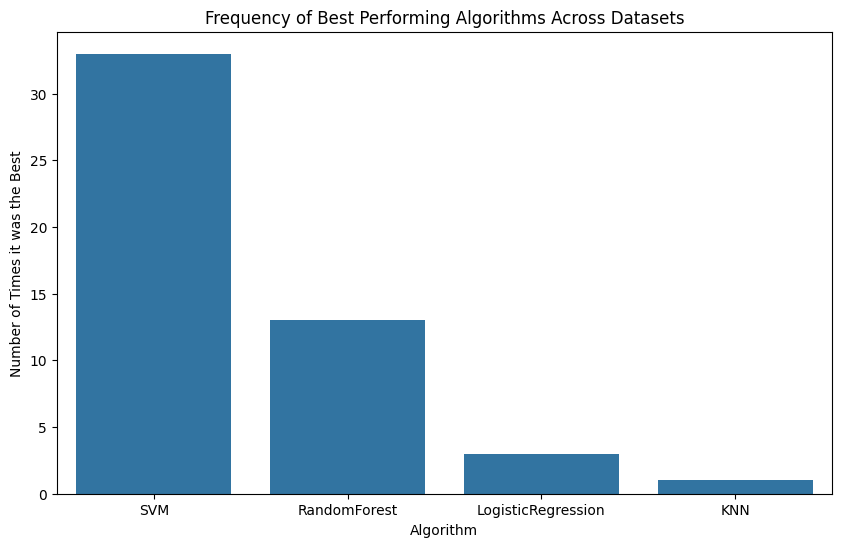

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='best_algorithm', data=meta_df, order=meta_df['best_algorithm'].value_counts().index)
plt.title('Frequency of Best Performing Algorithms Across Datasets')
plt.xlabel('Algorithm')
plt.ylabel('Number of Times it was the Best')
plt.show()

#### **Step 2.5: Train the Performance Model (The "Selector")**



We now have a "meta-dataset"! The features are the characteristics of each dataset (our meta-features), and the target is the name of the best algorithm.

We can train a machine learning model on this meta-dataset. This model will learn the relationship between dataset characteristics and algorithm performance. This is our **performance model** or **selector**.

We will use a `RandomForestClassifier` as our meta-model because they are generally robust and work well on tabular data.

In [ ]:
# Prepare the data for training the meta-model
X_meta = meta_df.drop('best_algorithm', axis=1)
y_meta = meta_df['best_algorithm']

# Split the meta-dataset into training and testing sets
X_meta_train, X_meta_test, y_meta_train, y_meta_test = train_test_split(
    X_meta, y_meta, test_size=0.3, random_state=42
)

# Our selector is a classifier trained on meta-data
selector_model = RandomForestClassifier(n_estimators=100, random_state=42)
selector_model.fit(X_meta_train, y_meta_train)

# Evaluate the selector model on the held-out meta-test set
selector_accuracy = selector_model.score(X_meta_test, y_meta_test)
print(f"Accuracy of our selector model: {selector_accuracy:.2f}")
print("This means our model can correctly predict the best algorithm for an unseen dataset about " + f"{selector_accuracy*100:.0f}% of the time.")

Accuracy of our selector model: 0.53
This means our model can correctly predict the best algorithm for an unseen dataset about 53% of the time.


### **Part 3: Evaluation (20 mins)**

Now for the crucial part. How good is our system? We need to compare its performance on **new, unseen datasets** against some baselines. As discussed on slide 39, we'll use:

*   **Single Best Solver (SBS):** The algorithm from our portfolio that performs best *on average* across all the *training* datasets. This is our "naive" baseline.
*   **Virtual Best Solver (VBS):** The theoretical "perfect" selector. For each test dataset, it magically knows and picks the best-performing algorithm. This represents the upper bound on performance.

#### **Step 3.1: Identify the Single Best Solver (SBS)**


Let's find the SBS from our training phase.


In [ ]:
sbs_name = meta_df['best_algorithm'].mode()[0]
print(f"The Single Best Solver (SBS) is: {sbs_name}")

The Single Best Solver (SBS) is: SVM



#### **Step 3.2: Create New "Test" Datasets**

Let's generate 10 new datasets that our system has never seen before.

In [ ]:
# Generate 10 new test datasets
n_test_datasets = 10
test_datasets = []

for i in range(n_datasets, n_datasets + n_test_datasets): # Use different random seeds
    n_samples = np.random.randint(200, 1000)
    n_features = np.random.randint(5, 50)
    n_informative = np.random.randint(2, n_features)
    n_redundant = np.random.randint(0, n_features - n_informative)
    n_classes = np.random.randint(2, 5)

    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_redundant=n_redundant,
        n_classes=n_classes,
        n_clusters_per_class=1,
        flip_y=0.05,
        random_state=i
    )
    test_datasets.append((X, y))

print(f"Generated {len(test_datasets)} new datasets for testing.")

Generated 10 new datasets for testing.


#### **Step 3.3: Evaluate Our Selector and the Baselines**

Now we will loop through each test dataset and do the following:
1.  Calculate the performance of **every** algorithm in our portfolio to find the ground truth.
2.  Determine the performance of the **Virtual Best Solver (VBS)** (the maximum achievable accuracy).
3.  Determine the performance of the **Single Best Solver (SBS)**.
4.  Use our **Selector** to predict the best algorithm, and then measure its actual performance.

In [ ]:
results = []

for i, (X_test, y_test) in enumerate(test_datasets):
    print(f"Evaluating on test dataset {i+1}/{len(test_datasets)}...")

    # --- 1. Get Ground Truth Performance for All Algorithms ---
    scaler = StandardScaler()
    X_test_scaled = scaler.fit_transform(X_test)

    actual_performances = {}
    for name, model in algorithm_portfolio.items():
        # For simplicity, we'll just test on a single train/test split here
        # In a real evaluation, you would use cross-validation
        X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(X_test_scaled, y_test, test_size=0.3, random_state=42)
        model.fit(X_train_part, y_train_part)
        predictions = model.predict(X_val_part)
        actual_performances[name] = accuracy_score(y_val_part, predictions)

    # --- 2. Determine VBS Performance ---
    vbs_performance = max(actual_performances.values())

    # --- 3. Determine SBS Performance ---
    sbs_performance = actual_performances[sbs_name]

    # --- 4. Use Our Selector to Predict and Evaluate ---
    # Extract meta-features from the new dataset
    test_meta_features = extract_meta_features(X_test, y_test)
    test_meta_df = pd.DataFrame([test_meta_features])

    # Predict the best algorithm
    predicted_algo_name = selector_model.predict(test_meta_df)[0]

    # Get the actual performance of the algorithm our selector chose
    selector_performance = actual_performances[predicted_algo_name]

    # Store results
    results.append({
        'Dataset': i+1,
        'Selector_Choice': predicted_algo_name,
        'Selector_Perf': selector_performance,
        'SBS_Perf': sbs_performance,
        'VBS_Perf': vbs_performance,
        'Actual_Best': max(actual_performances, key=actual_performances.get)
    })

results_df = pd.DataFrame(results)
print("\n--- Evaluation Results ---")
print(results_df)


Evaluating on test dataset 1/10...
Evaluating on test dataset 2/10...
Evaluating on test dataset 3/10...
Evaluating on test dataset 4/10...
Evaluating on test dataset 5/10...
Evaluating on test dataset 6/10...
Evaluating on test dataset 7/10...
Evaluating on test dataset 8/10...
Evaluating on test dataset 9/10...
Evaluating on test dataset 10/10...

--- Evaluation Results ---
   Dataset Selector_Choice  Selector_Perf  SBS_Perf  VBS_Perf  \
0        1             SVM       0.948187  0.948187  0.948187   
1        2             SVM       0.909910  0.909910  0.909910   
2        3             SVM       0.950943  0.950943  0.950943   
3        4             SVM       0.964286  0.964286  0.964286   
4        5             SVM       0.943396  0.943396  0.943396   
5        6    RandomForest       0.848214  0.830357  0.848214   
6        7             SVM       0.953846  0.953846  0.953846   
7        8    RandomForest       0.953390  0.966102  0.966102   
8        9             SVM       0.8

#### **Step 3.4: Final Comparison**

Let's look at the average performance across all test datasets.


--- Average Performance Across Test Datasets ---
Single Best Solver (SBS):  0.9266
Our Algorithm Selector:    0.9271
Virtual Best Solver (VBS): 0.9294


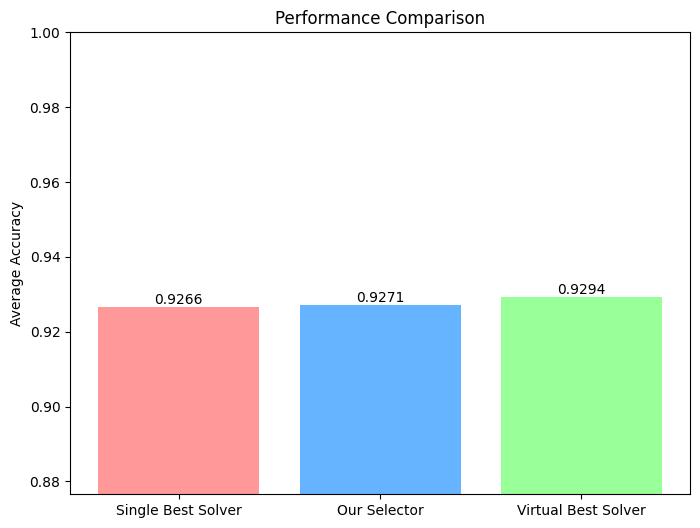

In [ ]:
avg_selector_perf = results_df['Selector_Perf'].mean()
avg_sbs_perf = results_df['SBS_Perf'].mean()
avg_vbs_perf = results_df['VBS_Perf'].mean()

print(f"\n--- Average Performance Across Test Datasets ---")
print(f"Single Best Solver (SBS):  {avg_sbs_perf:.4f}")
print(f"Our Algorithm Selector:    {avg_selector_perf:.4f}")
print(f"Virtual Best Solver (VBS): {avg_vbs_perf:.4f}")

# Visualize the comparison
labels = ['Single Best Solver', 'Our Selector', 'Virtual Best Solver']
scores = [avg_sbs_perf, avg_selector_perf, avg_vbs_perf]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, scores, color=['#ff9999','#66b3ff','#99ff99'])
plt.ylabel('Average Accuracy')
plt.title('Performance Comparison')
plt.ylim(bottom=min(scores) - 0.05, top=1.0)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center')

plt.show()

### **Part 4: Discussion & Wrap-up (10 mins)**

Look at the results.
*   Did our selector perform better than the Single Best Solver? Hopefully, yes! This shows that the intelligence we added was worthwhile.
*   How close did we get to the Virtual Best Solver? The gap between our selector and the VBS shows the room for improvement.

**Discussion Questions:**

1.  **Why isn't our selector perfect?**
    *   *Answer:* Our meta-features might not be descriptive enough. Our meta-model might not be powerful enough. We only used a limited number of "training" datasets.
2.  **How could we improve our selector?**
    *   *Answer:* Add more informative meta-features (statistical, information-theoretic, etc., as on slide 27). Use a larger and more diverse set of training datasets. Use a more sophisticated meta-model.
3.  **What is the main cost of building this system?**
    *   *Answer:* The offline computation (Step 2.4), where we have to run every algorithm on every training dataset. This can take a very long time for large portfolios and dataset collections. The cost of extracting meta-features must also be cheaper than just running the algorithm itself (slide 26).

**Congratulations!** You have just built and evaluated a complete, albeit simple, AutoML algorithm selection system from scratch. You've seen how we can use machine learning to solve the problem of choosing the best machine learning algorithm.